# A. Introduction

I conducted basic exploratory data analysis to explore patterns and correlations within an MLB batter's performance metrics dating from 1985. I also attempted to highlight important factors that contribute to a team reaching the postseason (playoffs). I plan to use some of the insights gained from the following rudimentary data exploration for other personal projects such as using machine learning to determine whether a team is undervaluing or overvaluing a player, understanding player performance regression, as well as predicting the number of team wins given historical stats of players in the team.  

This project uses data from Sean Lahman's Baseball Database. The URL of the source of the data is http://www.seanlahman.com/baseball-archive/statistics/.
This work is licensed under a Creative Commons Attribution-ShareAlike 3.0 Unported License. For details see: http://creativecommons.org/licenses/by-sa/3.0/

Lahman's baseball database has 24 different csv tables. I've chosen three of them for this analysis: "Batting.csv", "BattingPost.csv", and "Salaries.csv". 

- **Batting.csv**: Each instance contains information about a player's performance metrics in a given season as well as the team and the league he played in. The `playerID` key represents a player. When a player is traded to a different team within a given year, the statistics are treated separate and recorded in separate rows of the dataframe. The number of these duplicates are indicated by the feature `stint`, representing the number of "stints" a player has had in a given season. The dataset contains information from 1871 to 2020. 

    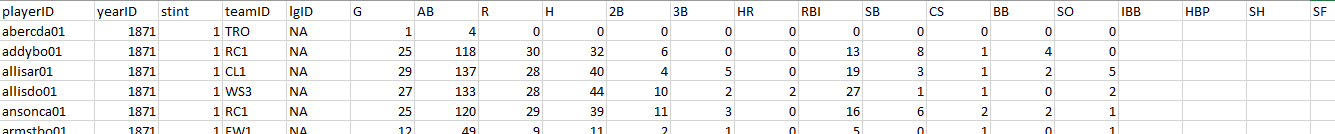
    
    <br>

- **BattingPost.csv**: This contains mostly the same information as Batting.csv, using the same `playerID` key. But for the postseason. Each instance represents a player's performance metric in a given year in a given round of the playoffs (e.g. World Series). The rounds are indicated by the feature `round`, which effectively replaces `round` from Batting.csv. The dataset contains information from 1884 to 2020. 

    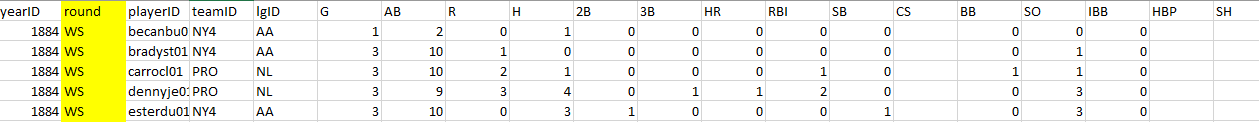


- **Salaries.csv**: This also uses the same `playerID` key, with each instance containing how much salary a player has earned in that given year (in USD). This dataset contains information from 1985 to 2020. 

    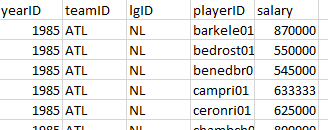


In the initial exploration stage, I attempted to confirm patterns and trends based on knowledge I have about baseball statistics. Then, via EDA, I attempted to identify the greatest determinant of a team making it into the postseason. I hypothesized that the total cumulative runs of a team in a given season would be one of the best predictors of the team making it to the postseason.

<br>

# B. Setting Up/Data Preprocessing

Across all three datasets there is a `playerID` key that identifies a player. I decided to merge the datasets into one dataset on the key, as well as conduct some additional cleaning and feature engineering.

Loading Tidyverse and Unprocessed datasets

In [182]:
options(warn=-1)
options(repr.matrix.max.cols=40, repr.matrix.max.rows=25) 
# maximum num of visible rows/columns in the notebook
library(tidyverse)
# telling R to use dplyr's select, not MASS's
select <- dplyr::select
batting = read_csv("data/Batting.csv", col_types = cols())
batting_post = read_csv("data/BattingPost.csv", col_types = cols())
salaries = read_csv("data/Salaries.csv", col_types = cols())

I took the following steps

1. Cut out all data from before 1985 to make data easier to handle, and also to ensure that most data had salary information as salary information is only available from 1985. 
2. Aggregated all of the metrics from a single player in the postseason given a year, across all rounds. 
2. To distinguish stats from regular season and Postseason, added a binary indicator variable `postseason` saying whether the statistic was from a regular season or Postseason.
3. Created a new identifier variable `playerseasonID` that identifies a statistic for a player in a specific year for a specific team, for all three tables
4. Merged the three datasets into one
5. Added new variables `BA` (Batting average) and `Kperc` (Strikeout percentage) which can be calculated from the given information. 
6. Added a new variable `postseason_app` (postseason appearance) indicating whether a team that the player played for that season ended up making it to the playoffs or not.


In [183]:
# Applying filters to select only batting data from 1985
batting <- filter(batting, yearID >= 1985)
batting_post <- filter(batting_post, yearID >= 1985)

# aggregating all of player's data for a postseason round in a given year 
batting_post <- batting_post %>%
    group_by(playerID, yearID, teamID, lgID) %>% 
    summarize_if(is.numeric, sum, na.rm=TRUE) %>%
    # adding an indicator variable for playoff appearance prior to merging 
    add_column(playoff = 1)

# Creating new ID key for each player and the year/team they played in
merged_batting <- bind_rows(batting, batting_post) %>% # merging by concatenation
    unite('playerseasonID', c("yearID", "playerID", "teamID"), remove = FALSE) %>%
    mutate(postseason = if_else(is.na(playoff), 0, 1)) %>% #postseason indicator
    # deleting previous postseason indicator variable
    dplyr::select(-playoff)

# Creating a variable that indicate whether a player played for a team that played in the postseason.
merged_batting_postseason_app <- merged_batting %>% group_by(playerseasonID) %>%
  summarise(postseason_app = max(postseason)) %>%
  inner_join(merged_batting, by = "playerseasonID") %>%
  mutate(postseason = if_else(postseason == 1, 'Y', 'N')) %>%
  mutate(postseason_app = if_else(postseason_app == 1, 'Y', 'N'))

# Merging with Salary Data and adding new metrics
df <- salaries %>%
  unite('playerseasonID', c("yearID", "playerID", "teamID"), remove = FALSE) %>%
  dplyr::select('playerseasonID', 'salary') %>%
  right_join(merged_batting_postseason_app, by = "playerseasonID") %>% 
  mutate(BA = H/AB) %>% # batting average 
  mutate(Kperc = SO/AB) %>% # strikeout percentage
  # reordering columns 
  relocate(salary, .after = last_col()) %>%
  relocate(c(playerseasonID, playerID, yearID, teamID, stint, lgID)) %>%
  relocate(c(postseason, postseason_app), .after = lgID) %>%
  relocate(c(BA, Kperc), .after = AB)

head(df)

playerseasonID,playerID,yearID,teamID,stint,lgID,postseason,postseason_app,G,AB,BA,Kperc,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary
1985_barkele01_ATL,barkele01,1985,ATL,1,NL,N,N,20,17,0.0000000,0.41176471,0,0,0,0,0,0,0,1,0,7,0,0,0,0,0,870000
1985_bedrost01_ATL,bedrost01,1985,ATL,1,NL,N,N,37,64,0.0781250,0.34375000,3,5,0,0,0,1,0,0,1,22,0,0,NA,0,0,550000
1985_benedbr01_ATL,benedbr01,1985,ATL,1,NL,N,N,70,208,0.2019231,0.05769231,12,42,6,0,0,20,0,1,22,12,1,1,NA,NA,8,545000
1985_campri01_ATL,campri01,1985,ATL,1,NL,N,N,66,13,0.2307692,0.38461538,1,3,0,0,1,2,0,0,1,5,0,0,1,0,0,633333
1985_ceronri01_ATL,ceronri01,1985,ATL,1,NL,N,N,96,282,0.2163121,0.08865248,15,61,9,0,3,25,0,3,29,25,1,1,0,NA,15,625000
1985_chambch01_ATL,chambch01,1985,ATL,1,NL,N,N,101,170,0.2352941,0.12941176,16,40,7,0,3,21,0,0,18,22,NA,0,0,1,5,800000


Data Exploration will be done on this single dataset. 

# C. Initial Data Exploration

Here I attempt to play around with the dataframe, and ensure whether the dataset reflects common sense knowledge about baseball. 

### 1. Batting Average Distribution 

Batting average is the most widely used metric for getting a general idea of a player's hitting ability. It indicates the number of hits `H` a player had divided by the number of chances (“at bats”) `AB` a player was given. The higher the average, the better. Around .240~.260 is considered average. Above .300 is considered elite. Below .200 is considered poor. On a distribution graph I expect to see a peak somewhere around .250.



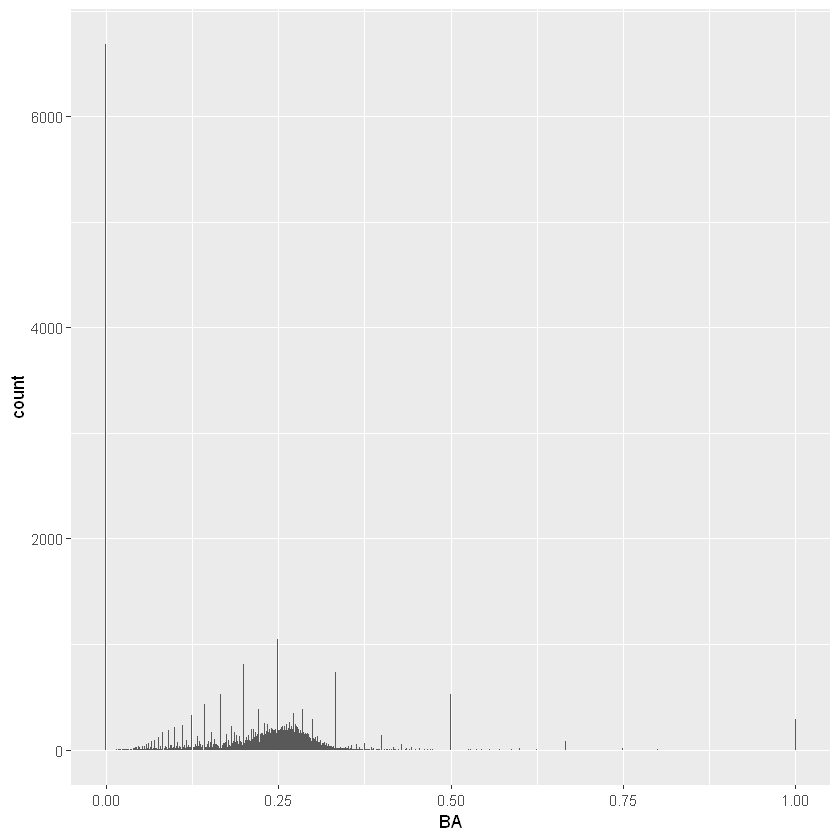

In [184]:
df %>%
  ggplot() +
  geom_histogram(mapping = aes(x = BA), binwidth = 0.001)

We do see a peak around 0.25, but we see an incredibly high number of 0. This is most likely because the Lahman database includes data from all players, including those who may have only had a few at bats and did not manage to get any hits. We can increase the minimum at bat threshold to 100 (`AB > 100`) to eliminate the 0 values.



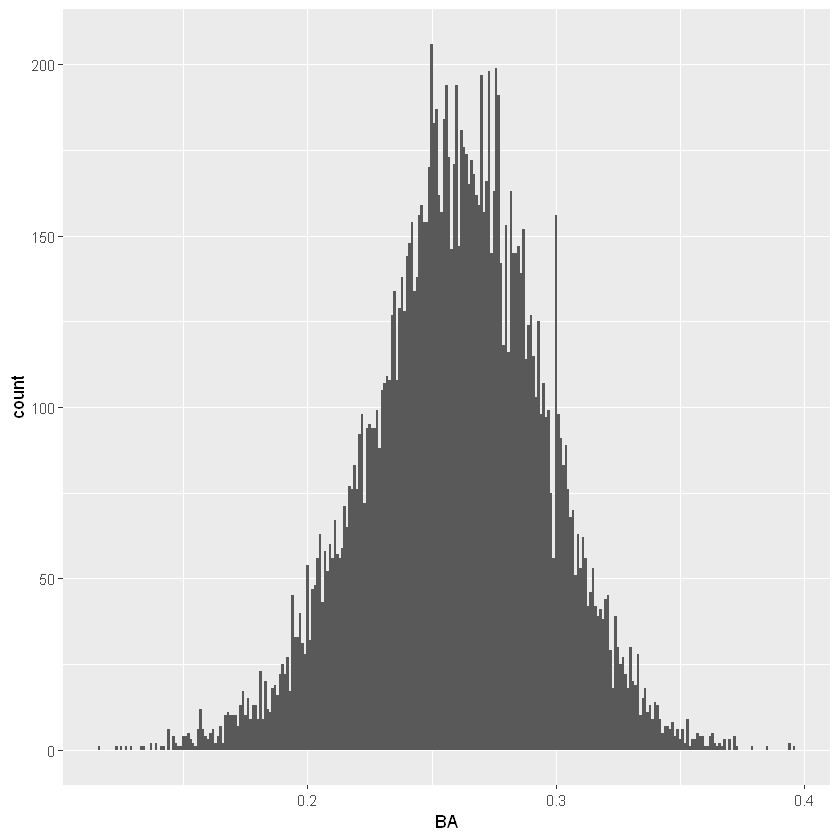

In [185]:
df %>%
  filter(AB > 100) %>%
  ggplot() +
  geom_histogram(mapping = aes(x = BA), binwidth = 0.001)

This looks a lot like what we were looking for. We can increase the threshold even further to look at players who had more than 400 AB.

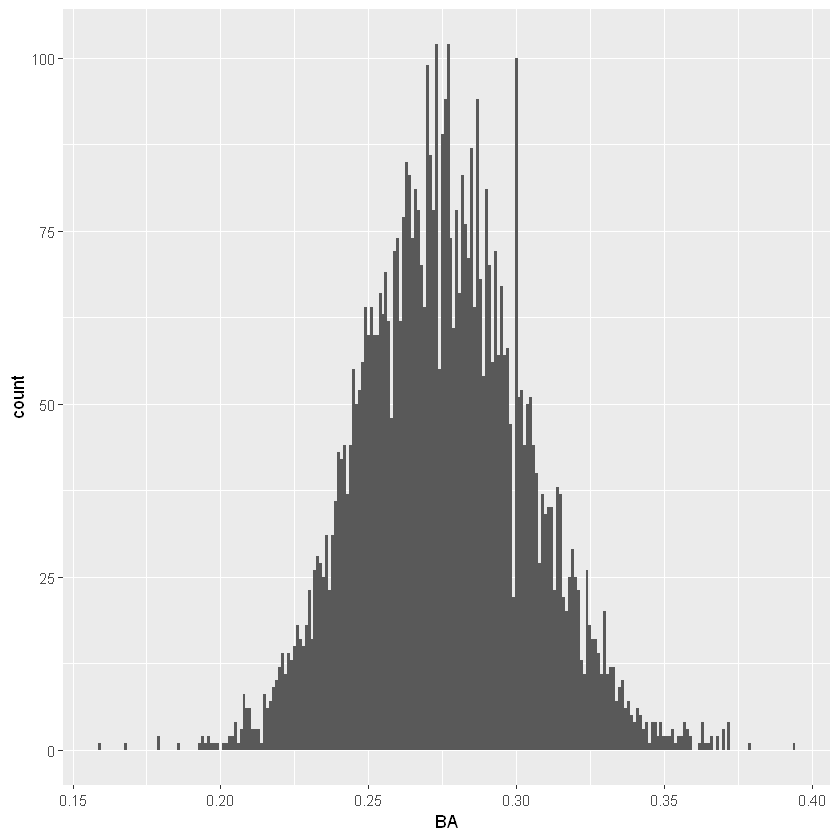

In [186]:
df %>%
  filter(AB > 400) %>%
  ggplot() +
  geom_histogram(mapping = aes(x = BA), binwidth = 0.001)

The distribution seems very similar, although if you look closely there is a slight shift of the distribution to the right. It makes sense that players that have had a higher number of chances to bat have a higher batting average. Players that are more skilled are more likely to be given chances to bat. We can confirm this by calculating the mean for both scenarios.

In [187]:
df %>%
  filter(AB > 100) %>%
  summarise(meanBA = mean(BA, na.rm = T)) %>% 
  add_column(' ' = "More than 100 At Bats") %>% 
  relocate(' ')
df %>%
  filter(AB > 400) %>%
  summarise(meanBA = mean(BA, na.rm = T)) %>%
  add_column(' ' = "More than 400 At Bats") %>% 
  relocate(' ')

,meanBA
More than 100 At Bats,0.25991


,meanBA
More than 400 At Bats,0.2757304


In the `BA` distribution graph there seems to be a random spike at ~0.300. Taking a closer look: 

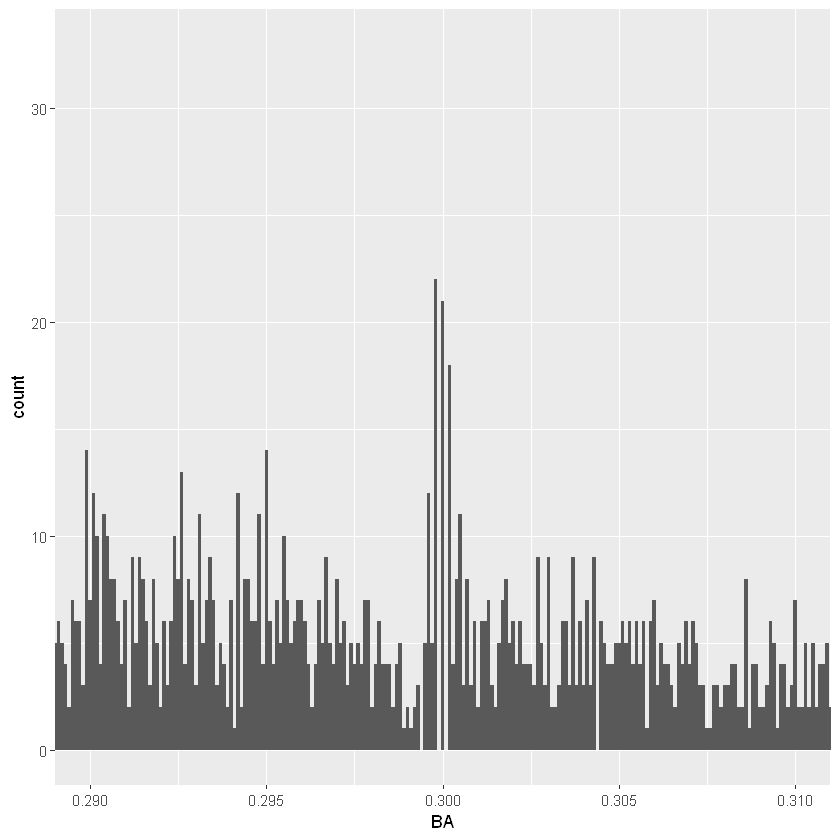

In [188]:
df %>%
  filter(AB > 400) %>%
  ggplot() +
  geom_histogram(mapping = aes(x = BA), binwidth = 0.0001) +
  coord_cartesian(xlim = c(0.29, 0.31))

In [189]:
df %>% 
    filter(AB > 400 & BA == .300) %>%
    dplyr::select(playerseasonID, yearID, postseason, AB, H, BA)

playerseasonID,yearID,postseason,AB,H,BA
1986_fletcsc01_TEX,1986,N,530,159,0.3
1987_jacobbr01_CLE,1987,N,540,162,0.3
1991_caldeiv01_MON,1991,N,470,141,0.3
1993_gonzalu01_HOU,1993,N,540,162,0.3
1995_vaughmo01_BOS,1995,N,550,165,0.3
1995_oneilpa01_NYA,1995,N,460,138,0.3
1996_martial03_PIT,1996,N,630,189,0.3
1998_brosisc01_NYA,1998,N,530,159,0.3
1999_liebemi01_PHI,1999,N,510,153,0.3
2000_floydcl01_FLO,2000,N,420,126,0.3


Upon examining the data, there doesn’t seem to be anything particularly odd or unusual. Making `binwidth` smaller revealed that many players had batting averages that round to 0.300, and not all of them equate to exactly 0.3. I wanted to see if there are other spikes around other “common” numbers of batting average, such as “0.250” or “0.200" to reveal any potential peculiarities.

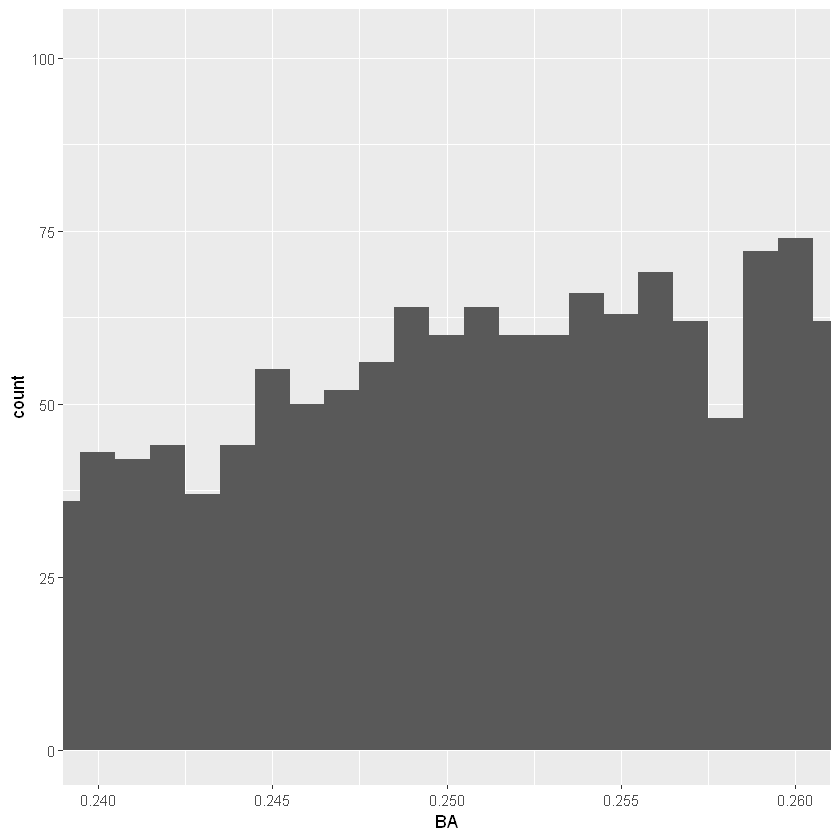

In [190]:
df %>%
  filter(AB > 400) %>%
  ggplot() +
  geom_histogram(mapping = aes(x = BA), binwidth = 0.001) +
  coord_cartesian(xlim = c(0.24, 0.26))

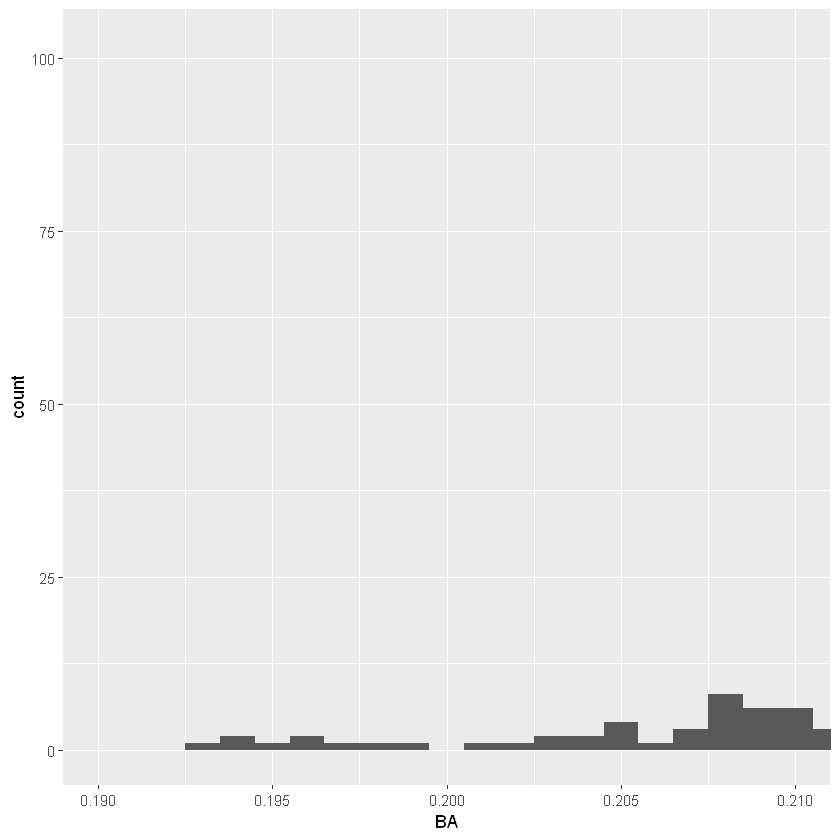

In [191]:
df %>%
  filter(AB > 400) %>%
  ggplot() +
  geom_histogram(mapping = aes(x = BA), binwidth = 0.001) +
  coord_cartesian(xlim = c(0.19, 0.21))

No unusually high peaks exist at 0.250 or 0.200. I will conclude that the peak at 0.300 is purely by chance.

### 2. Home Run Distribution

From my rough estimate coming from my knowledge of basic MLB stats, the average number of homeruns hit are probably around 10-15, but this number is limited to players who had a lot of `AB`s. Number of home runs hit in a season will have a higher variance than batting average, as it varies widely on a player by player basis. 

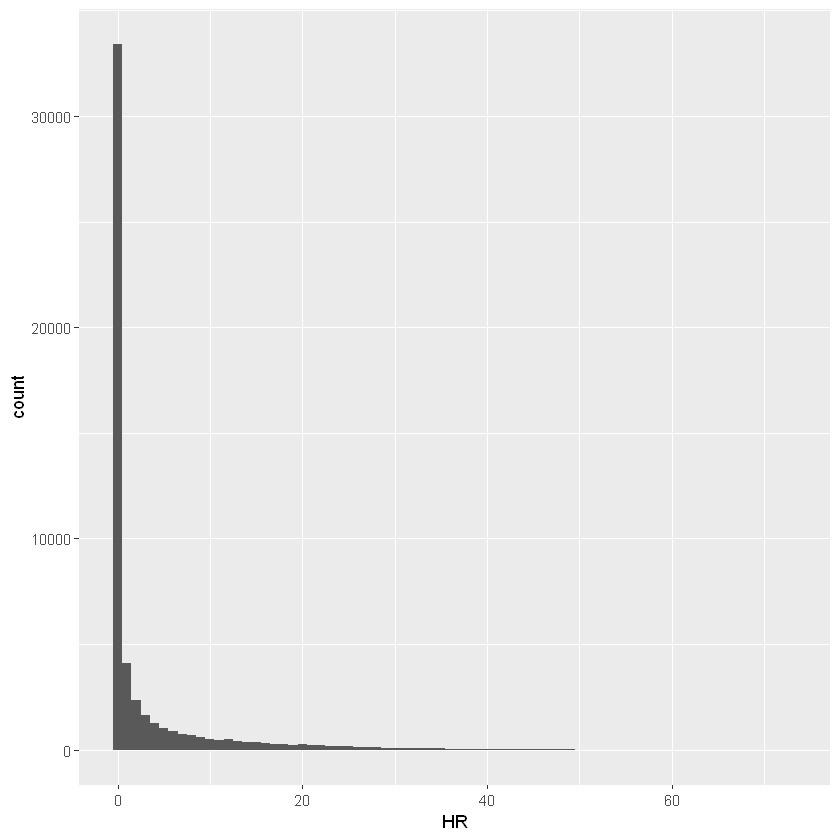

In [192]:
df %>%
  ggplot() +
  geom_histogram(mapping = aes(x = HR), binwidth = 1)

Again, a high number of 0 home runs. We need to bring up the AB threshold again.



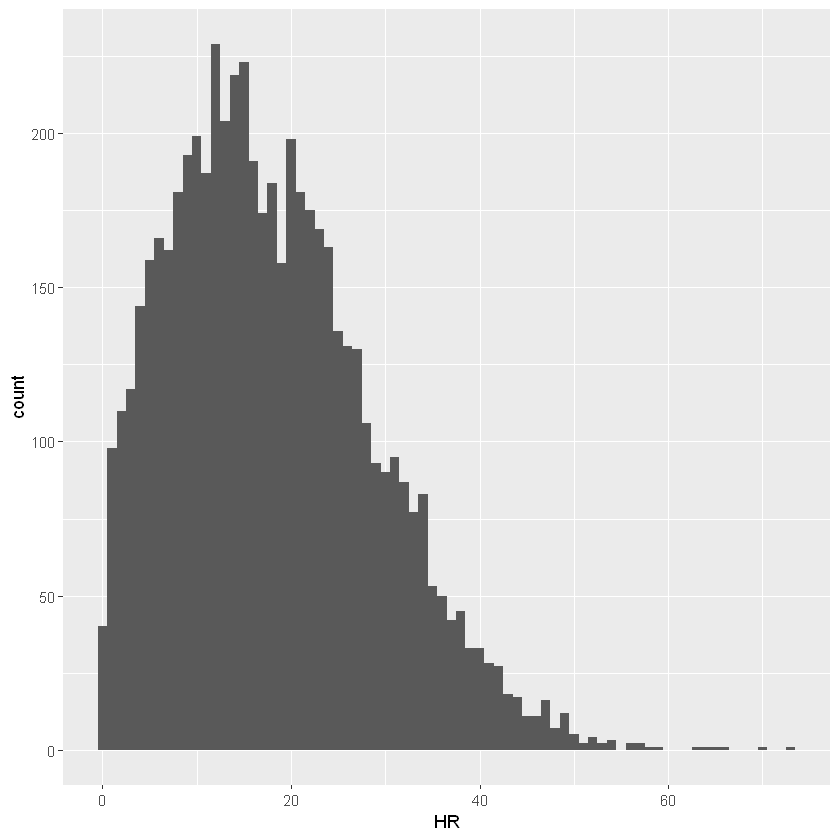

In [193]:
df %>%
  filter(AB > 400) %>%
  ggplot() +
  geom_histogram(mapping = aes(x = HR), binwidth = 1)

We do see a peak around 15 `HR`. There seems to be a greater right skew compared to the batting average distribution graph, which looked more like a normally distributed graph. This can be explained by the fact that there are fewer players who have a lot of power that can hit many home runs.

I wanted to see if there are any statistic that correlate with the number of home runs hit. Let’s filter for players that had at least 400 `AB` and above a 0.3 `BA`.

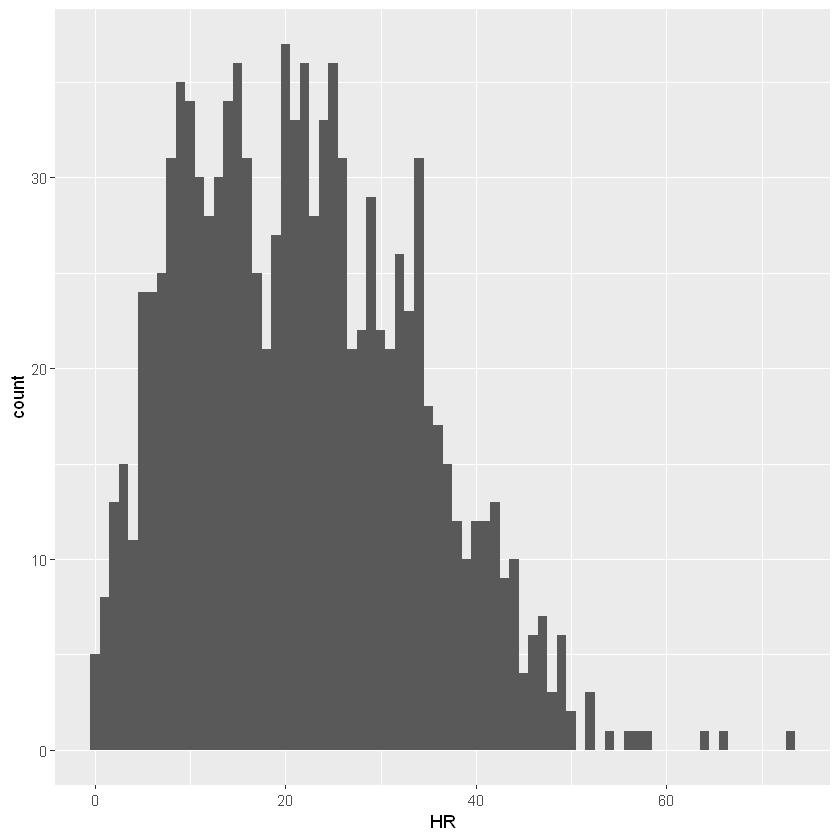

In [194]:
df %>% 
  filter (AB > 400 & BA > 0.3) %>%
  ggplot() + 
  geom_histogram(mapping = aes(x = HR), binwidth = 1)

The graph seems slightly more normally distributed and the skew is less obvious, discounting the outliers of players who has hit more than 50 home runs. The distribution has shifted a bit right as well, hinting that a high batting average has some correlation with high numbers of homeruns hit.\
\
We can check out another statistic called `RBI`. `RBI` is short for Runs Batted In, or the number of runs a player caused to be scored. Home run hitters tend to have a high RBI. We'll see if this is a better predictor of the number of home runs hit. I will filter for players who had more than 100 RBI, which usually indicates that a player had an extremely good season. 


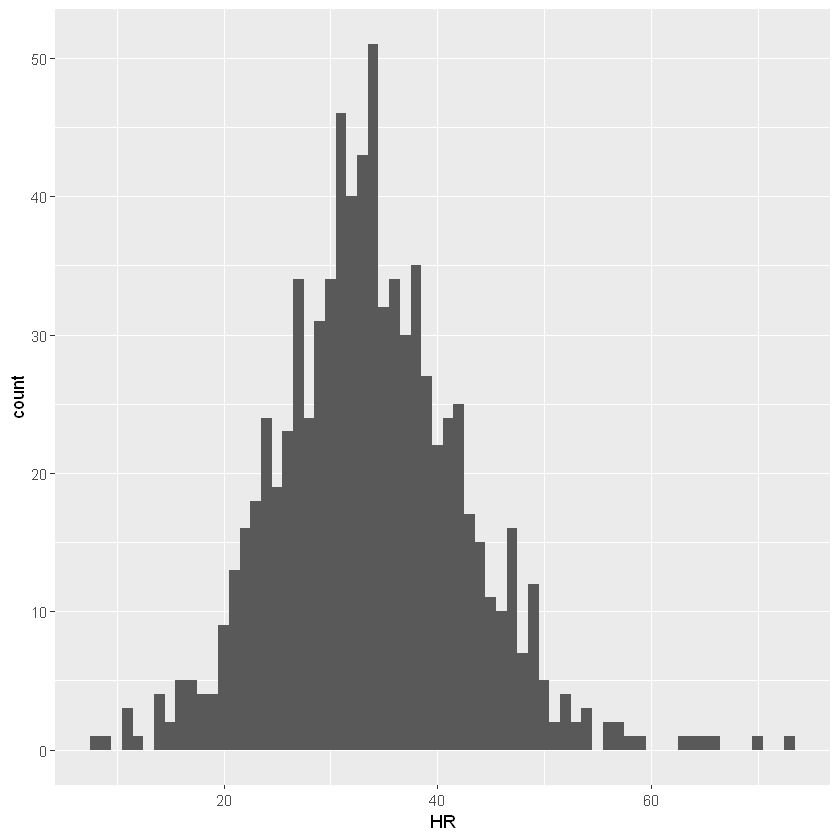

In [195]:
df %>% 
  filter (AB > 400 & RBI > 100) %>%
  ggplot() + 
  geom_histogram(mapping = aes(x = HR), binwidth = 1)

The graph here has even less skew and has a more rightward shift compared to the other graphs, peaking at around 30 HRs. `RBI` seems to be a better predictor of number of `HR` hit. We can use a scatterplot to confirm this.

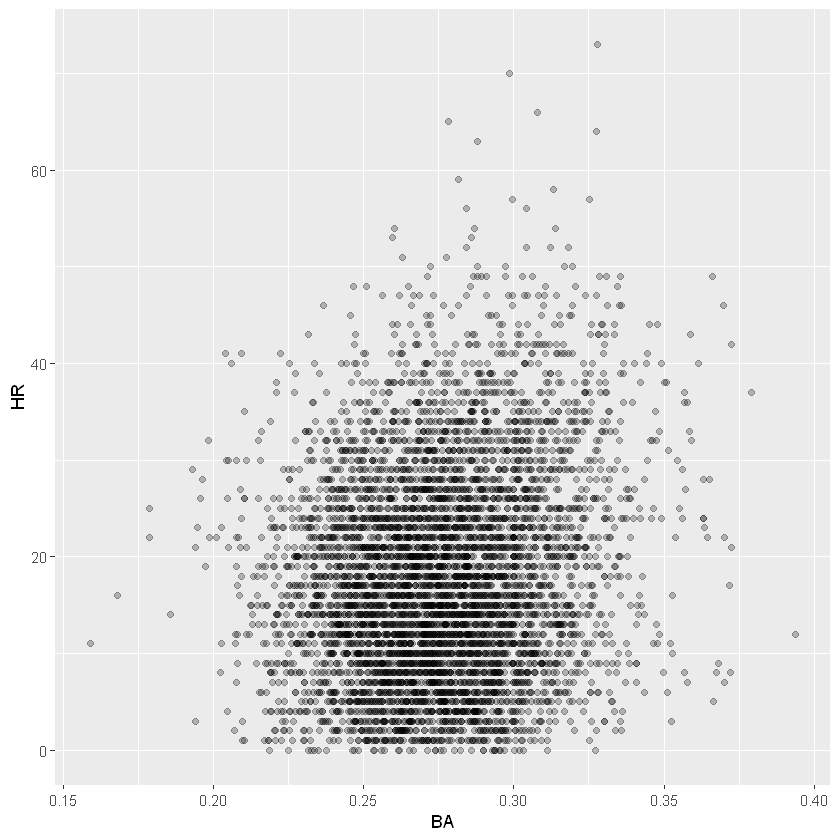

In [196]:
df %>%
  filter (AB > 400) %>% 
  ggplot() +
  geom_point(aes(x = BA, y = HR), alpha = 1/4)

It's kind of hard to see a clear correlation between `BA` and `HR`. Using `RBI` instead...

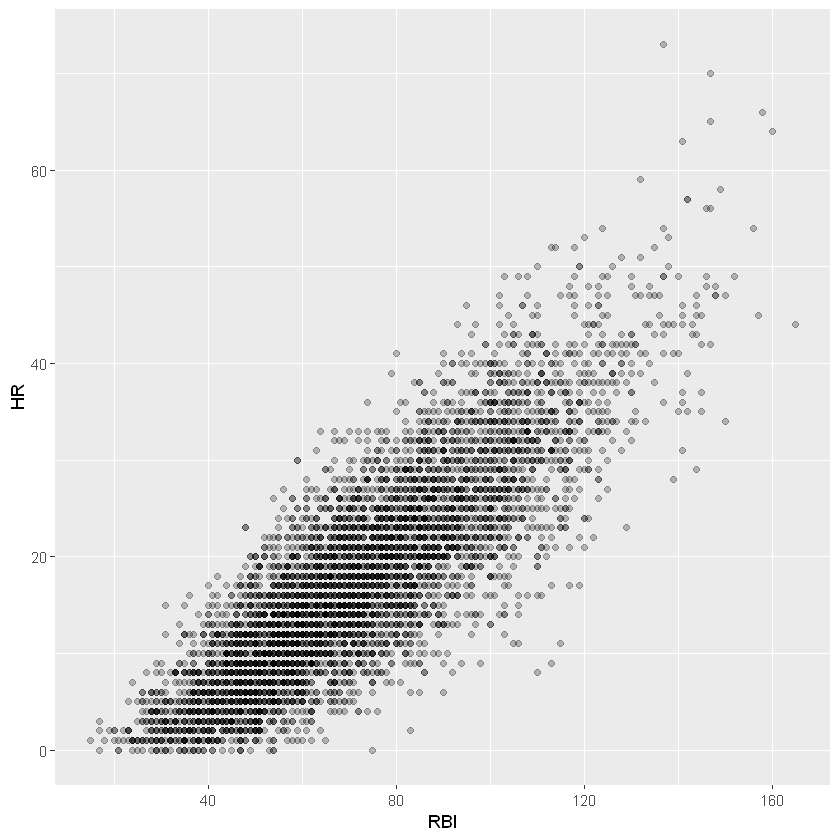

In [197]:
df %>%
  filter (AB > 400) %>% 
  ggplot() +
  geom_point(aes(x = RBI, y = HR), alpha = 1/4)

The correlation seems much higher here. A home run awards at least one `RBI`, often times more if there are existing players on base, so the correlation makes sense. 

I wanted to try another variable, `BB`. `BB` or "Base on Balls", more commonly known as "walks" is the number of times a player has drawn four balls. Good players often draw more walks. High home run hitters tend to have high `BB` as well. 

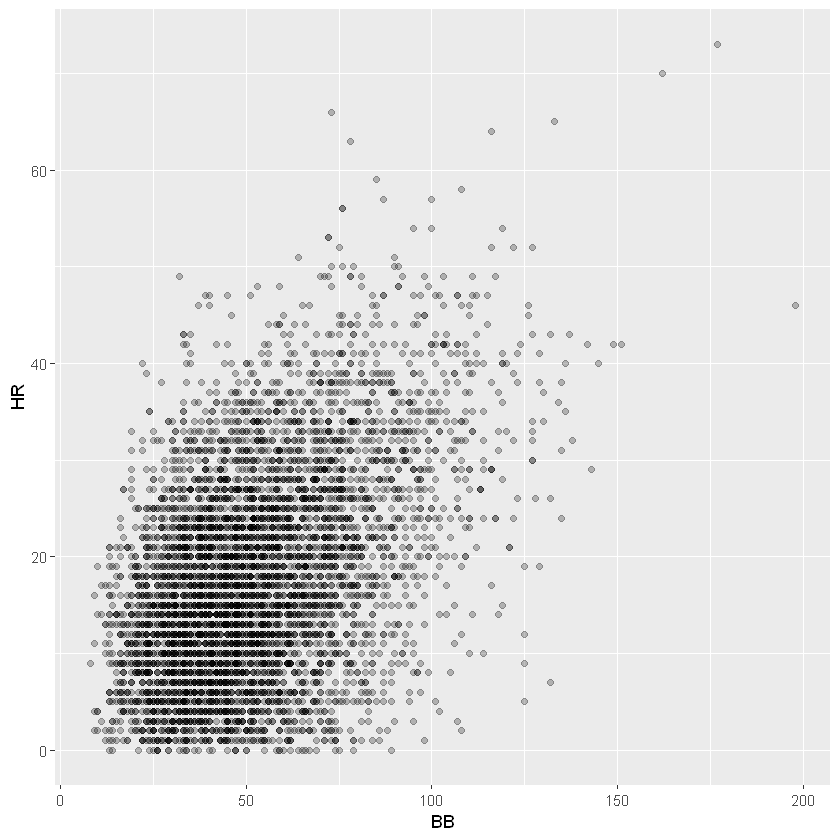

In [198]:
df %>%
  filter (AB > 400) %>% 
  ggplot() +
  geom_point(aes(x = BB, y = HR), alpha = 1/4)

The correlation seems a bit better than batting average, but it is not as clear as `RBI`.

Numerically calculating the correlation coefficient, we can see that in terms of predicting `RBI`, `HR`>`BB`>`BA`.

In [199]:
df %>%
  filter (AB > 400) %>%
  select(HR, BA) %>%
  cor()
df %>%
  filter (AB > 400) %>%
  select(HR, RBI) %>%
  cor()
df %>%
  filter (AB > 400) %>%
  select(HR, BB) %>%
  cor()

,HR,BA
HR,1.0000000,0.1647233
BA,0.1647233,1.0000000


,HR,RBI
HR,1.000000,0.847853
RBI,0.847853,1.000000


,HR,BB
HR,1.0000000,0.4518436
BB,0.4518436,1.0000000


### 3. Salary 

We are given salary information in this dataframe. We can expect salary to increase over the years, considering inflation rates. We can attempt to view the distribution.


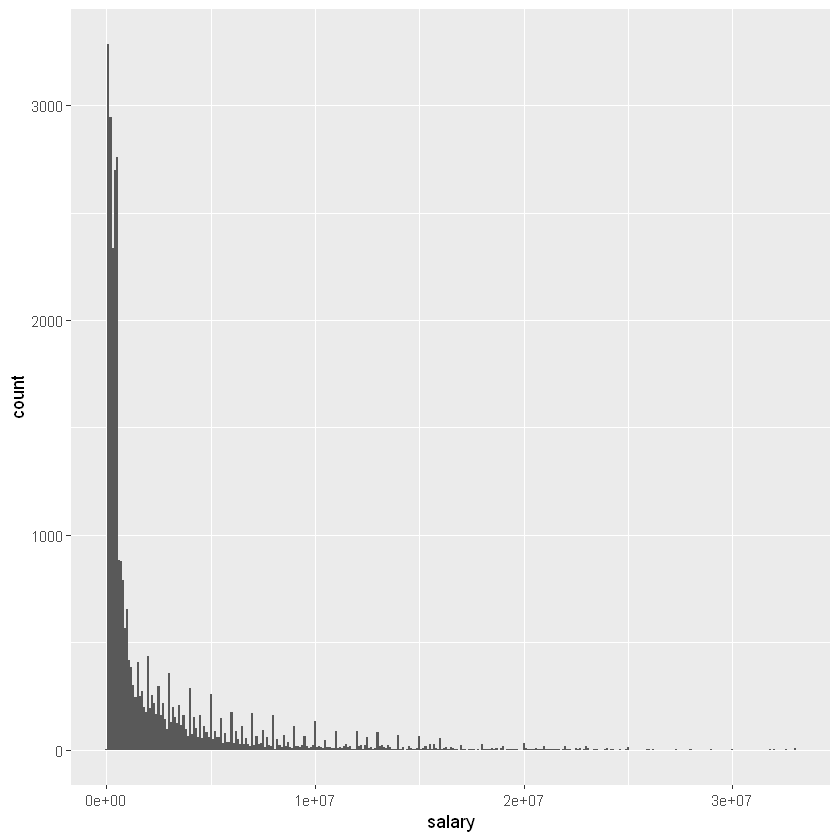

In [200]:
df %>%
  ggplot() +
  geom_histogram(mapping = aes(x = salary), binwidth = 100000)

There is a high concentration of players receiving near 0 salary. We can attempt to remove some of them by filtering to players with over 400 `AB`.


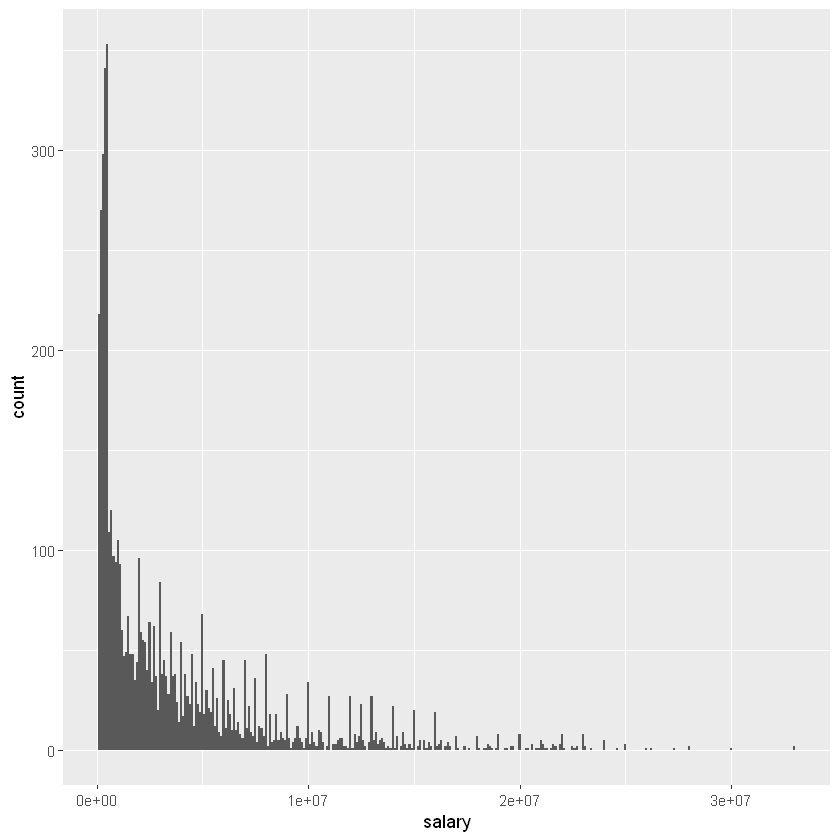

In [201]:
df %>%
  filter (AB > 400) %>%
  ggplot() +
  geom_histogram(mapping = aes(x = salary), binwidth = 100000)

We see a similar graph here. It's not particularly informative other than the fact that most players in the MLB receive a salary of lower than 1 million. Let's compare the salary received vs. year.


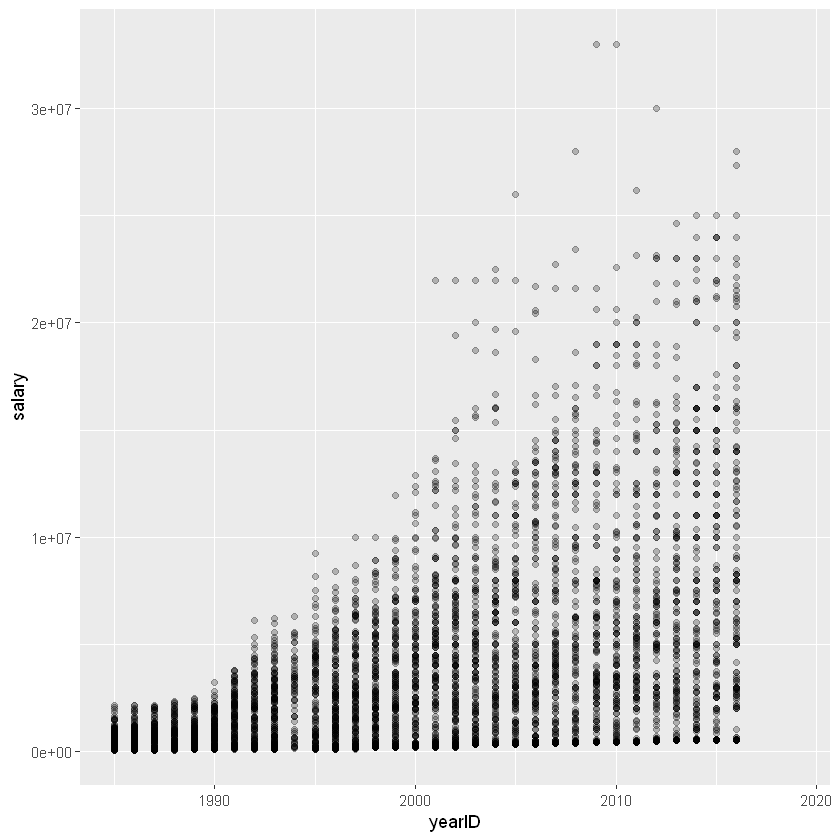

In [202]:
df %>%
  filter(AB>400) %>%
  ggplot() + 
  geom_point(mapping = aes(x = yearID, y = salary), alpha = 1/4)

The reason the graph looks like this is because the year data is in integers (aka, no 1995.3 year) But there does seem to be a trend of rising mean salary over the years. \
\
I can convert the years from numeric to a factor type and view the years as a categorical variable, then view a boxplot for each of these years.

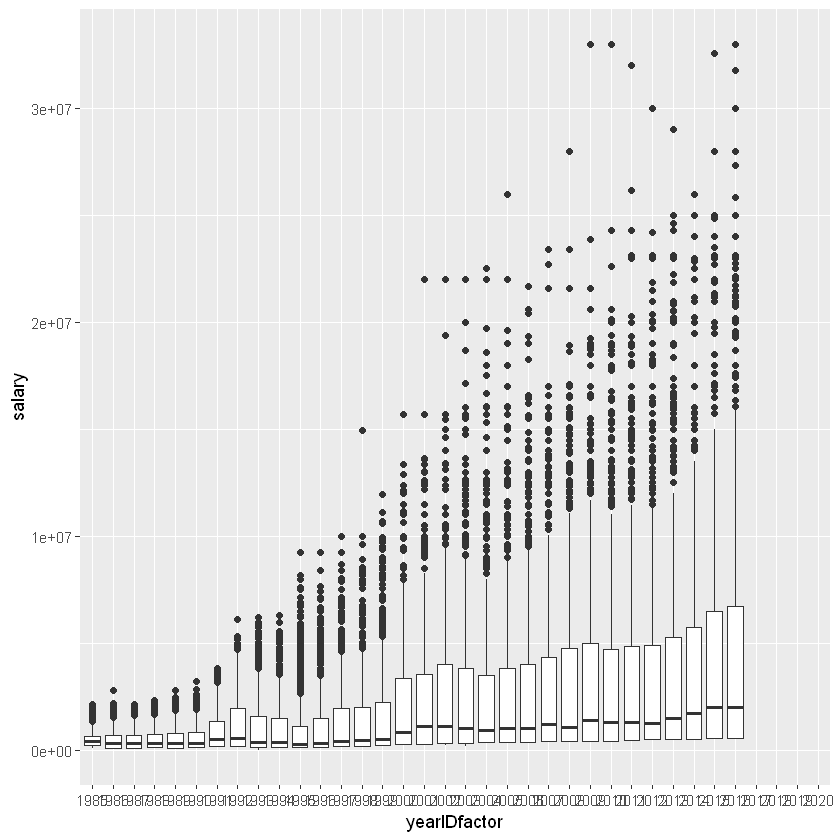

In [203]:
df$yearIDfactor = as.factor(df$yearID)
df %>%
  ggplot(mapping = aes(x = yearIDfactor, y = salary)) +
  geom_boxplot()

There is a very slight trend in increase of mean salary per year, but the outliers become even higher throughout the years. We can create a separate graph only focusing on the increase of mean salary to see the numbers for them more clearly.

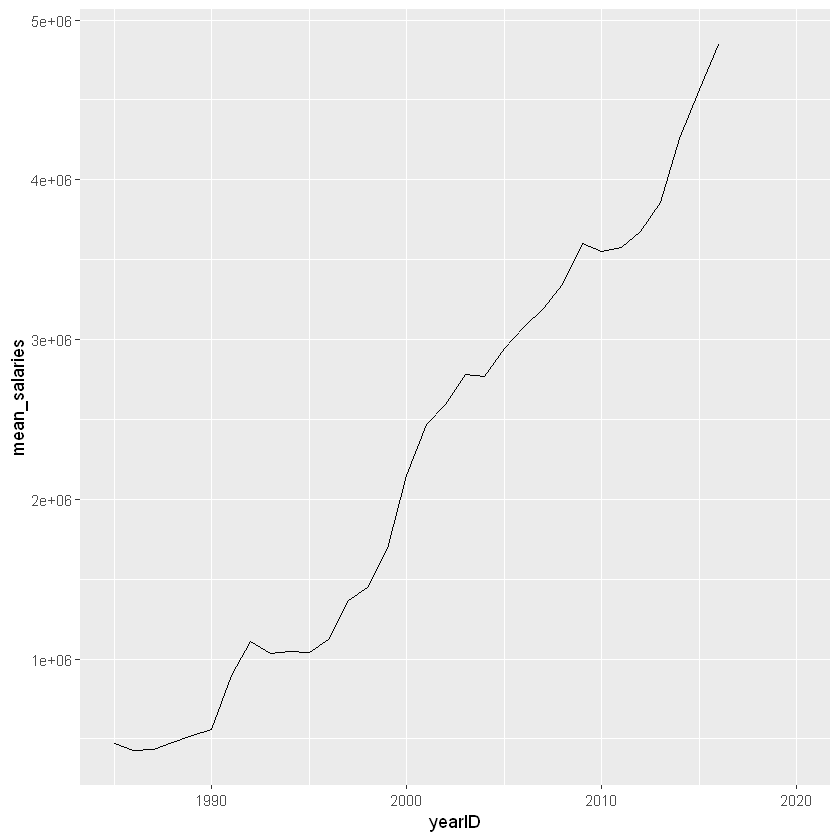

In [204]:
df %>%
  group_by(yearID) %>%
  summarise(mean_salaries = mean(salary, na.rm = TRUE)) %>%
  ggplot() +
  geom_line(mapping = aes(x = yearID, y = mean_salaries))

We can see the mean salary increase from lower than 1 million from 1985 to around 5 million in 2016. However, the outliers (players with some of the highest paid salaries) underwent an even more dramatic increase as evidenced by the boxplot, some receiving over 30 million dollars a year. This can be explained by a dramatic increase in MLB teams' revenues in recent years.\
\
We will return to salaries for a more in depth analysis.

# D. Identifying Predictors for Team Postseason Appearance

We will attempt to identify variables that would predict a team's likelihood of entering the postseason.

### 1. Setting up

Because we are now talking in terms of teams, I created a new dataframe that contains statistic of a team's season by merging the data with group_by.

New variables that indicate a team's collective performance:
- `total_AB` total at bats by a team
- `total_HR` total home runs by a team
- `total_H` total hits by a team
- `total_R` total runs by a team
- `total_SO` total strikeouts by a team
- `total_GIDP` total `GIDP` by a team
    - `GIDP` refers to "Ground into double play" which is a bad thing for the batter and produces two outs.
- `total_salary` total salary paid by a team (payroll)

I also created new variables that measures the ratio of these statistics for a whole team's season. 
- `total_BA` The team's collective batting average
- `total_Kperc` The team's collective strikeout per AB
- `total_HRperc` The team's collective HR per AB
- `total_RRatio` The team's collective Runs produced per AB
- `total_GIDPperc` The team's collective `GIDP` produced per AB




In [205]:
teamsummary <- df %>%
  group_by(yearID, teamID) %>%
  summarise(total_AB = sum(AB, na.rm=TRUE), total_H = sum(H, na.rm=T), 
            total_HR = sum(HR, na.rm = T),  total_R = sum(R, na.rm = T), 
            total_SO = sum(SO, na.rm = T), total_salary = sum(salary, na.rm = T), 
            total_GIDP = sum(GIDP, na.rm = T)) %>%
  mutate(total_BA = total_H/total_AB, 
         total_Kperc = total_SO/total_AB, 
         total_HRperc = total_HR/total_AB,
         total_RRatio = total_R/total_AB,
         total_GIDPperc = total_GIDP/total_AB) %>%
  arrange(yearID, teamID)
head(teamsummary, 10)

`summarise()` has grouped output by 'yearID'. You can override using the `.groups` argument.


yearID,teamID,total_AB,total_H,total_HR,total_R,total_SO,total_salary,total_GIDP,total_BA,total_Kperc,total_HRperc,total_RRatio,total_GIDPperc
1985,ATL,5526,1359,126,632,849,14032000,154,0.2459283,0.1536374,0.02280130,0.1143684,0.02786826
1985,BAL,5517,1451,214,818,908,11560712,132,0.2630053,0.1645822,0.03878920,0.1482690,0.02392605
1985,BOS,5720,1615,162,800,816,10299227,164,0.2823427,0.1426573,0.02832168,0.1398601,0.02867133
1985,CAL,5442,1364,153,732,902,12591227,138,0.2506431,0.1657479,0.02811466,0.1345094,0.02535832
1985,CHA,5470,1386,146,736,843,9846178,119,0.2533821,0.1541133,0.02669104,0.1345521,0.02175503
1985,CHN,5492,1397,150,686,937,12702917,119,0.2543700,0.1706118,0.02731245,0.1249090,0.02166788
1985,CIN,5431,1385,114,677,856,8359917,136,0.2550175,0.1576137,0.02099061,0.1246548,0.02504143
1985,CLE,5527,1465,116,729,817,6351666,139,0.2650624,0.1478198,0.02098788,0.1318980,0.02514927
1985,DET,5575,1413,202,729,926,9968143,81,0.2534529,0.1660987,0.03623318,0.1307623,0.01452915
1985,HOU,5582,1457,121,706,873,9293051,127,0.2610176,0.1563956,0.02167682,0.1264780,0.02275170


I then left merged this dataframe with another dataframe only containing the team's postseason appearance status by creating a new dataframe only containing the team, its year, and the postseason appearance stats `postseason_app`. 

In [206]:
teamsPSapp <- df %>% 
  select(teamID, yearID, postseason_app) %>%
    unique()
teamsummary <- left_join(teamsummary, teamsPSapp, by = c("teamID", "yearID")) %>%
  select(yearID, teamID, postseason_app, total_BA, total_Kperc, 
         total_HRperc, total_RRatio, total_GIDPperc, total_salary, everything())%>%
  arrange(yearID, teamID) 

Finally, I included another variable that displays the `yearID` as factors instead of integers.


In [207]:
teamsummary$yearIDfactor = as.factor(teamsummary$yearID)
head(teamsummary)

yearID,teamID,postseason_app,total_BA,total_Kperc,total_HRperc,total_RRatio,total_GIDPperc,total_salary,total_AB,total_H,total_HR,total_R,total_SO,total_GIDP,yearIDfactor
1985,ATL,N,0.2459283,0.1536374,0.02280130,0.1143684,0.02786826,14032000,5526,1359,126,632,849,154,1985
1985,BAL,N,0.2630053,0.1645822,0.03878920,0.1482690,0.02392605,11560712,5517,1451,214,818,908,132,1985
1985,BOS,N,0.2823427,0.1426573,0.02832168,0.1398601,0.02867133,10299227,5720,1615,162,800,816,164,1985
1985,CAL,N,0.2506431,0.1657479,0.02811466,0.1345094,0.02535832,12591227,5442,1364,153,732,902,138,1985
1985,CHA,N,0.2533821,0.1541133,0.02669104,0.1345521,0.02175503,9846178,5470,1386,146,736,843,119,1985
1985,CHN,N,0.2543700,0.1706118,0.02731245,0.1249090,0.02166788,12702917,5492,1397,150,686,937,119,1985


### 2. Total Batting Average 

Can we predict a team's likelihood to enter the postseason by looking at the team's collective batting average? 


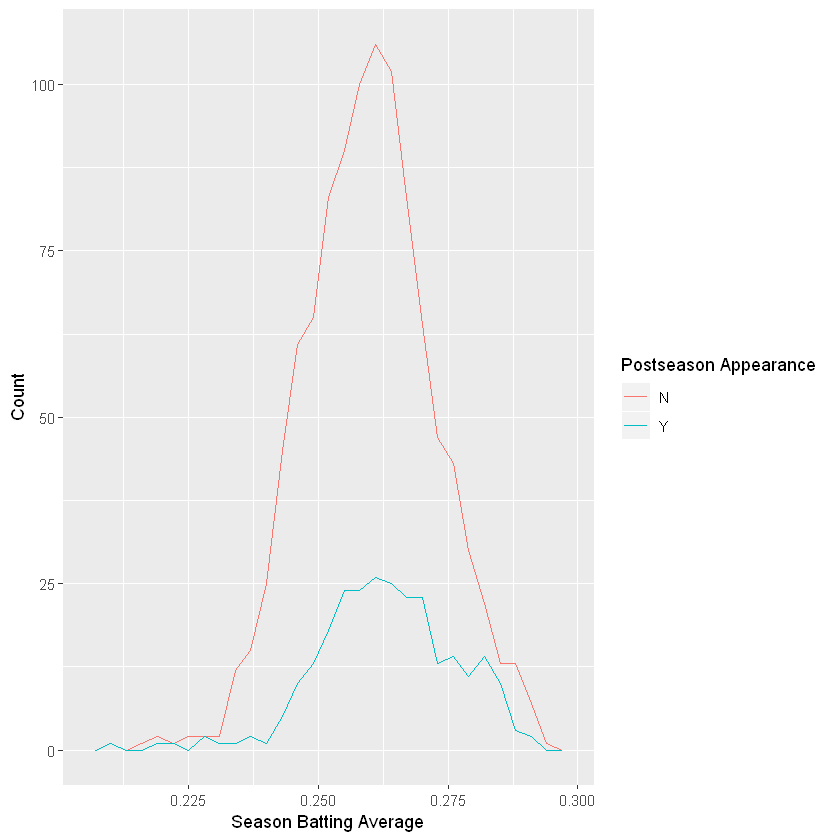

In [208]:
teamsummary %>%
  ggplot(mapping = aes(x = total_BA)) + 
  geom_freqpoly(mapping = aes(colour = postseason_app), binwidth = 0.003) +
  labs(x = "Season Batting Average", y = "Count", colour = "Postseason Appearance")

We would be comparing the shift and the pattern of the graph rather than the scale of these graphs, since there are obviously more data points for teams that didn't make the postseason. There doesn't seem like an obvious correlation, since the shape is pretty similar between the two graphs. 


### 3. Runs


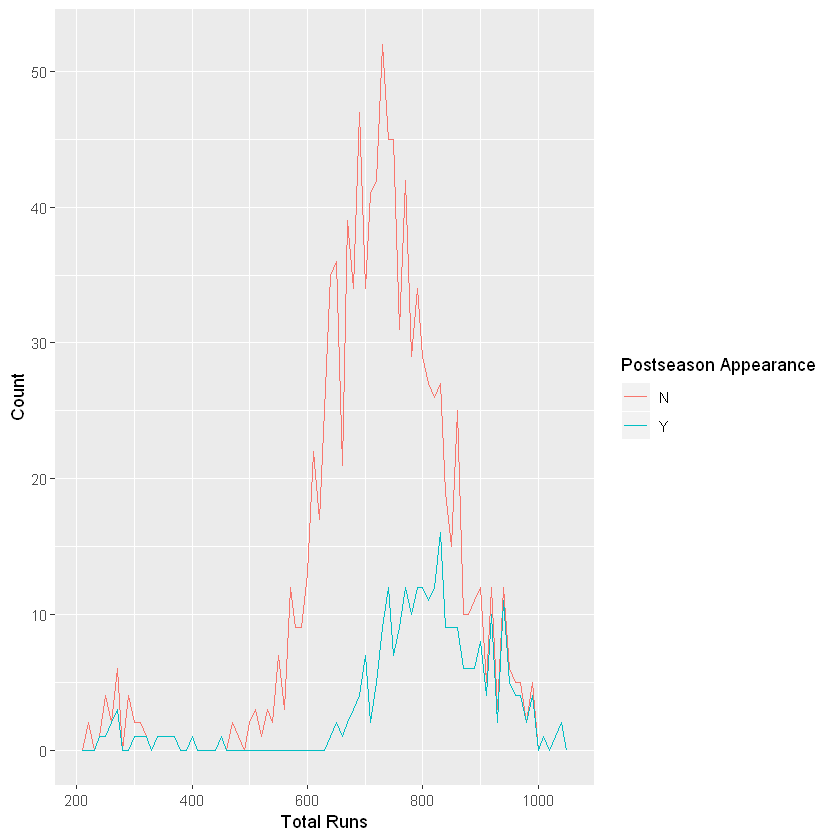

In [209]:
teamsummary %>%
  ggplot(mapping = aes(x = total_R)) + 
  geom_freqpoly(mapping = aes(colour = postseason_app), binwidth = 10) +
  labs(x = "Total Runs", y = "Count", colour = "Postseason Appearance")

It seems that the postseason graph is more skewed left (with a more rightward peak), meaning that teams that appeared on the postseason tend to have higher runs. Team's total runs do seem like a better indicator at least compared to the collective batting average. We can see a similar trend with `total_RRatio`, or a team's calculated run per At Bat. 

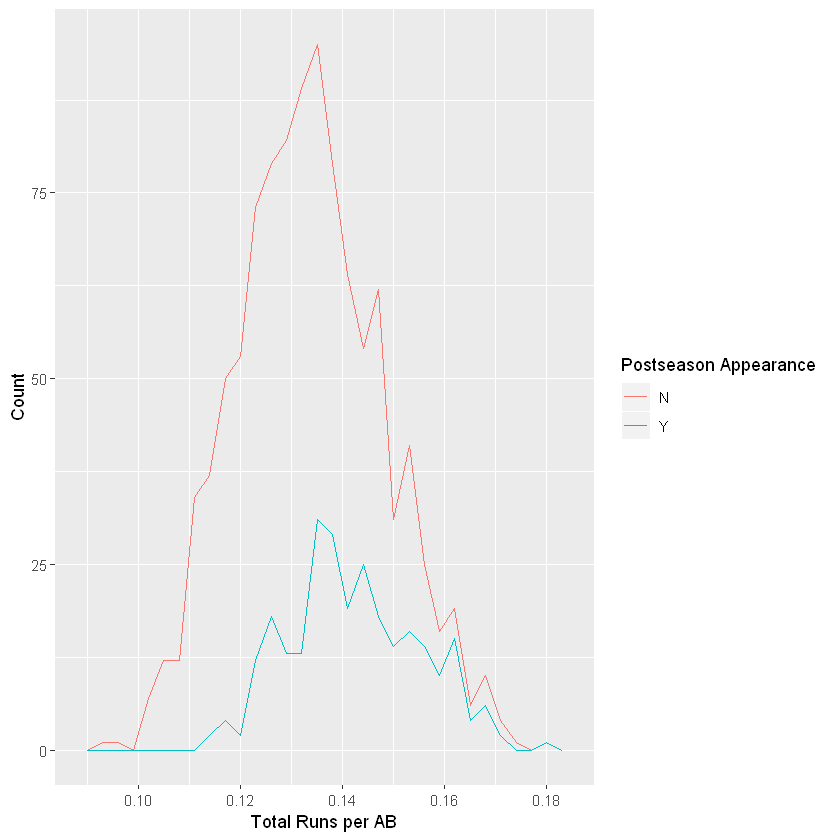

In [210]:
teamsummary %>%
  ggplot(mapping = aes(x = total_RRatio)) + 
  geom_freqpoly(mapping = aes(colour = postseason_app), binwidth = 0.003) +
  labs(x = "Total Runs per AB", y = "Count", colour = "Postseason Appearance")

Although the postseason team's graph seems a bit more rightward, I think that `total_R` is a better indicator of a team's postseason appearance likelihood. This makes sense given that a team's win is determined by the hard number of runs scored, not "run scored per at bat."


### 4. Home Runs

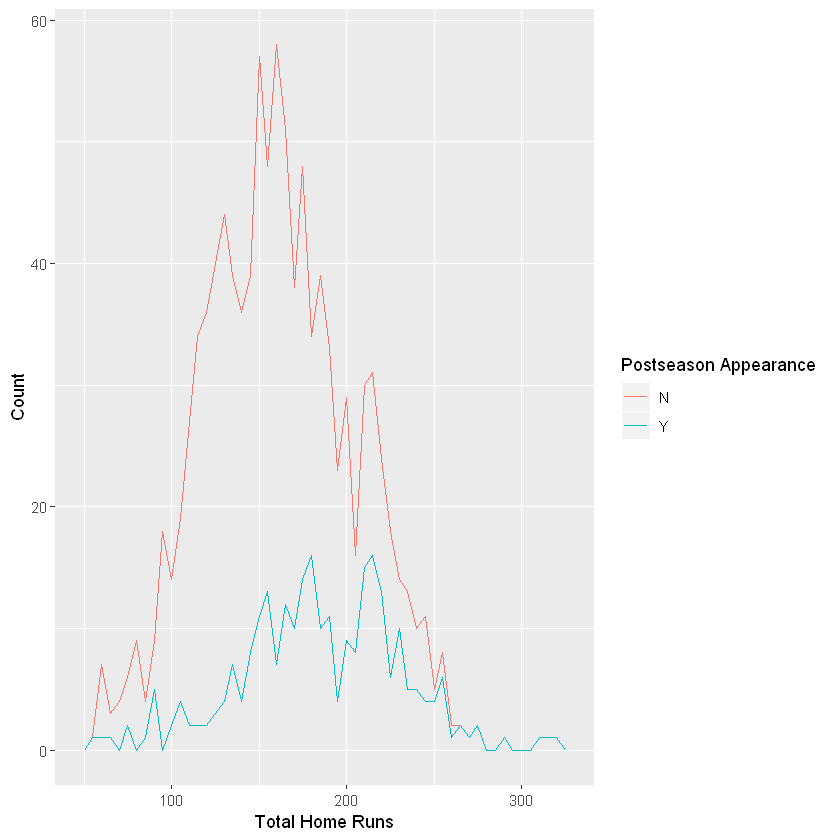

In [211]:
teamsummary %>%
  ggplot(mapping = aes(x = total_HR)) + 
  geom_freqpoly(mapping = aes(colour = postseason_app), binwidth = 5) +
  labs(x = "Total Home Runs", y = "Count", colour = "Postseason Appearance")

This is a similar graph to above `Total Runs` graph. There is an obvious skew left (rightward shift) for the postseason graph compared to the regular season graph. This makes sense because the number of home runs is directly correlated with the number of runs scored by a team. 


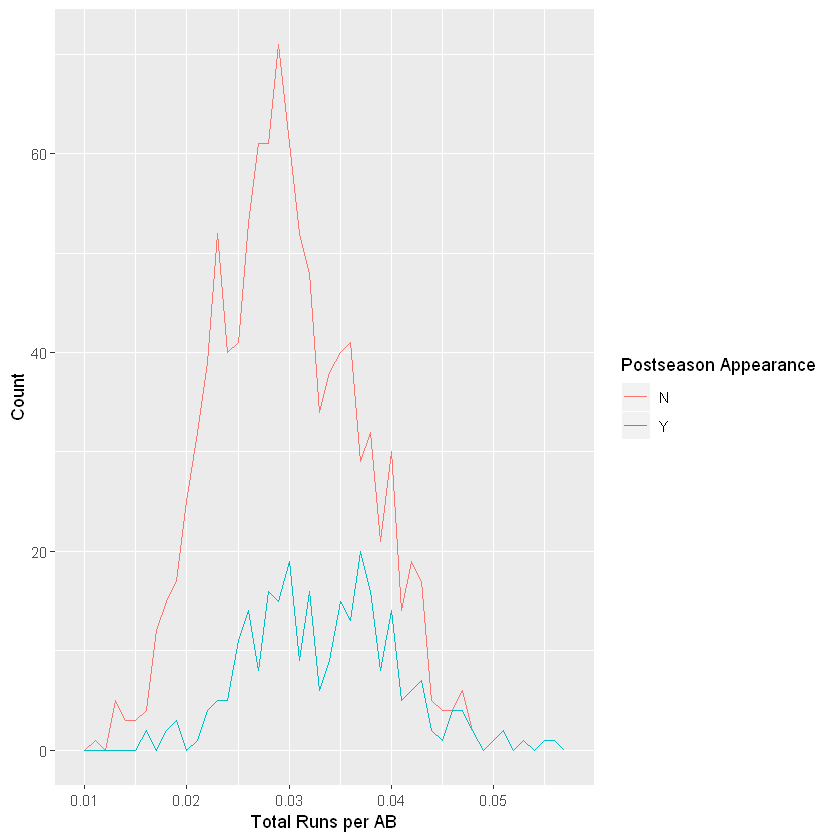

In [212]:
teamsummary %>%
  ggplot(mapping = aes(x = total_HRperc)) + 
  geom_freqpoly(mapping = aes(colour = postseason_app), binwidth = 0.001) +
  labs(x = "Total Runs per AB", y = "Count", colour = "Postseason Appearance")

Again, the HR ratio graph is similar to the Run ratio graph. You can see a clear rightward shift by the postseason graph, but it's not as evident as the "Total home run" graph. 


### 5. Strikeouts

Because strikeouts are bad for the team, would we see an opposite trend here compared to the above graphs?


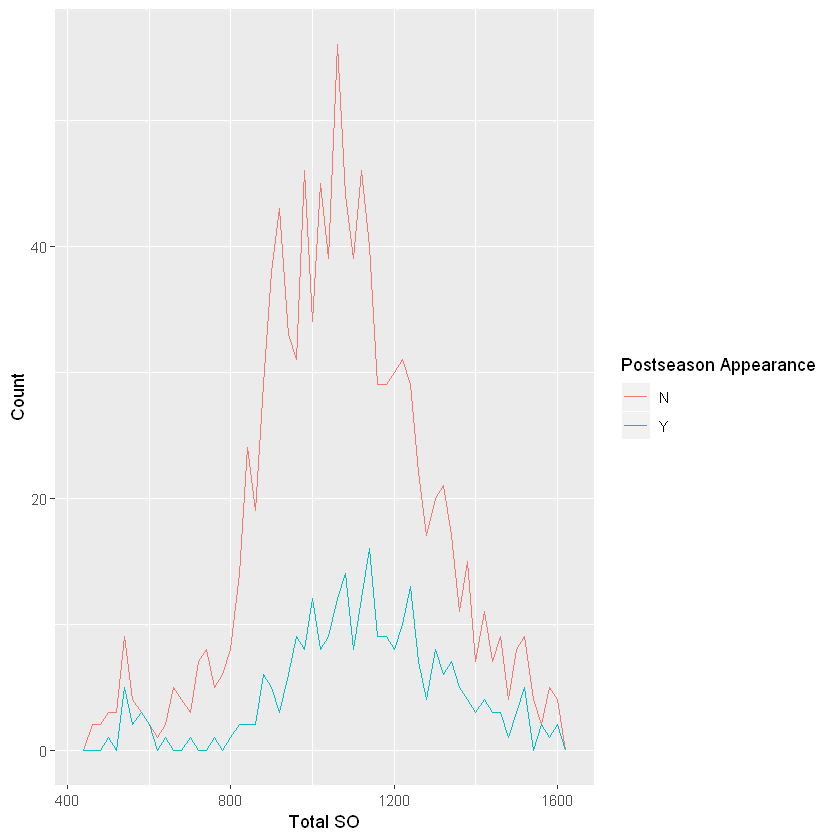

In [213]:
teamsummary %>%
  ggplot(mapping = aes(x = total_SO)) + 
  geom_freqpoly(mapping = aes(colour = postseason_app), binwidth = 20) +
  labs(x = "Total SO", y = "Count", colour = "Postseason Appearance")

The postseason graph for Total Strikeouts actually has a slight rightward shift. Does this suggest that a team's high strikeout count positively predicts the likelihood of a postseason appearance? We can also look at the collective strikeout rate of a team.


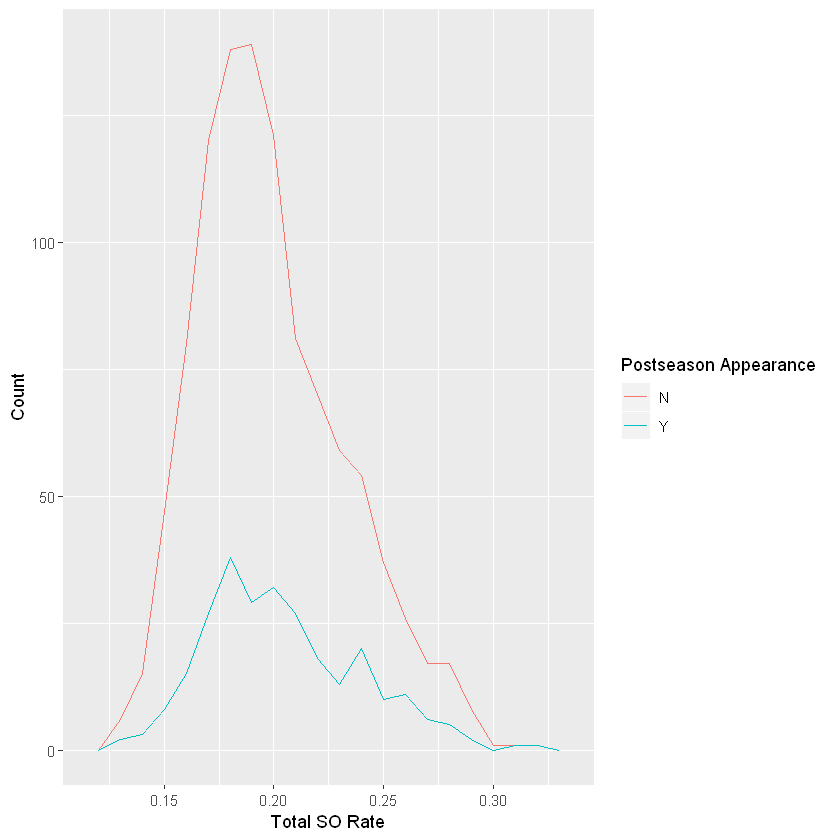

In [214]:
teamsummary %>%
  ggplot(mapping = aes(x = total_Kperc)) + 
  geom_freqpoly(mapping = aes(colour = postseason_app), binwidth = 0.01) +
  labs(x = "Total SO Rate", y = "Count", colour = "Postseason Appearance")

When looking at the strikeout rate rather than the count, the shift is not as obvious now. The postseason teams graph actually seems a bit more leftward-shifted. Strikeout rate is actually a better indicator of a team's skill than hard counts of how many strikeouts a team had. Contrary to "runs", the number of "strikeouts" a team accumulates doesn't necessarily lead to affecting the points in a game. A team with a high strikeout rate indicates that they are not able to efficiently convert opportunities to a productive play. A team with a high strikeout count can also have a low strikeout rate. 

### 6. GIDP
This logic is similar to `GIDP`, or "grounded in double play" counts/rates.


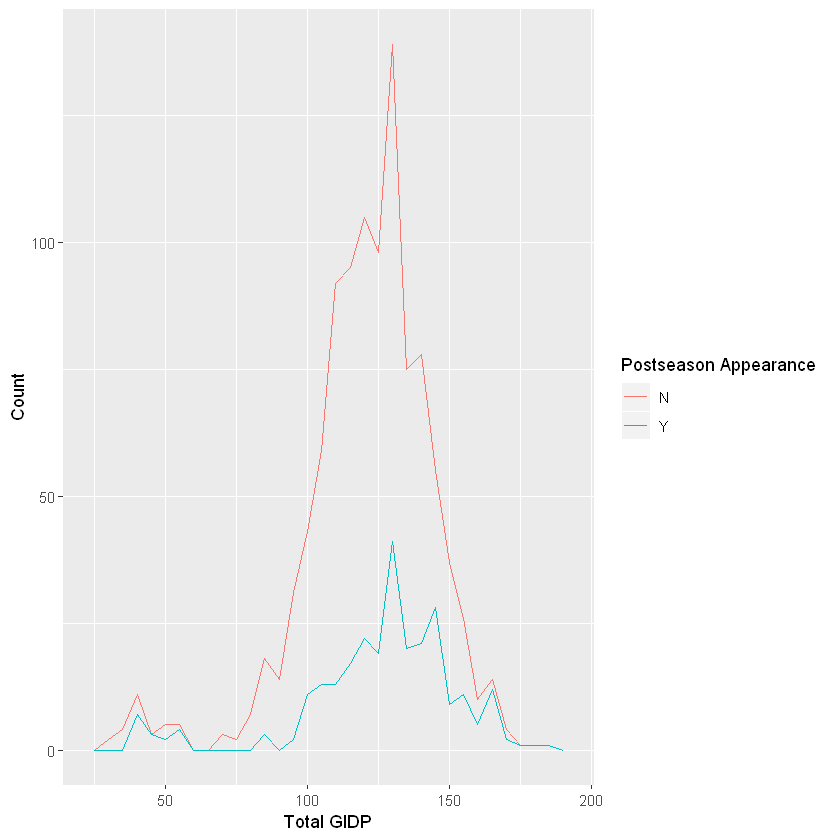

In [215]:
teamsummary %>%
  ggplot(mapping = aes(x = total_GIDP)) + 
  geom_freqpoly(mapping = aes(colour = postseason_app), binwidth = 5) +
  labs(x = "Total GIDP", y = "Count", colour = "Postseason Appearance")

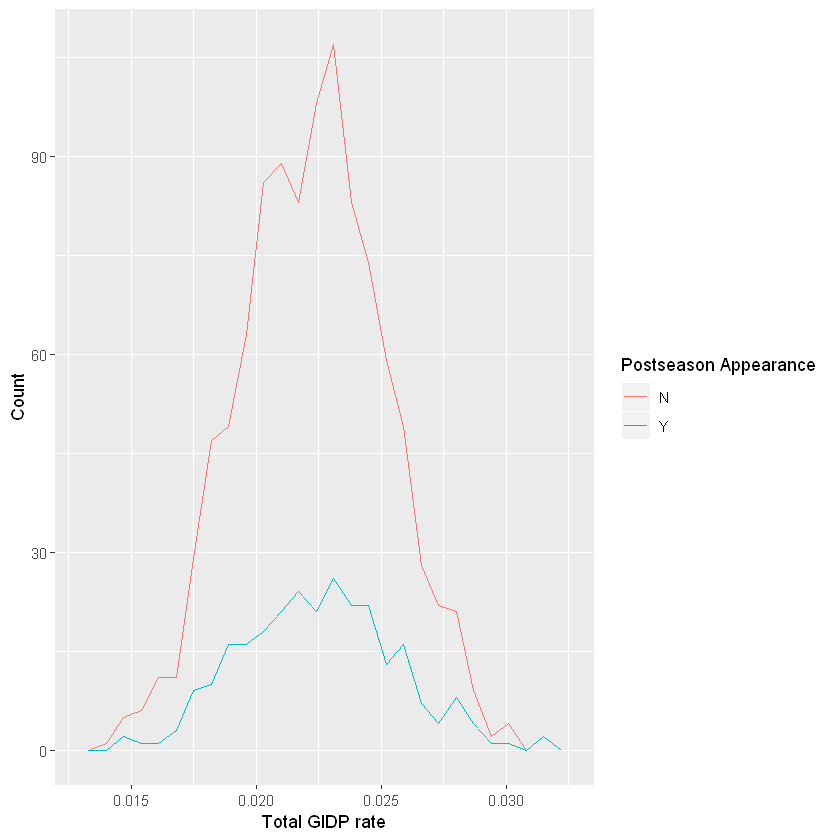

In [216]:
teamsummary %>%
  ggplot(mapping = aes(x = total_GIDPperc)) + 
  geom_freqpoly(mapping = aes(colour = postseason_app), binwidth = 0.0007) +
  labs(x = "Total GIDP rate", y = "Count", colour = "Postseason Appearance")

Both strikeout counts/rates and GIDP counts/rates are not as great predictor of a team's postseason appearance likelihood, compared to the number of runs and home runs that a team accumulates throughout the season. \
\
These scatterplots confirm that runs matter more than K rate and GIDP rate in determining a team's postseason appearance likelihood.

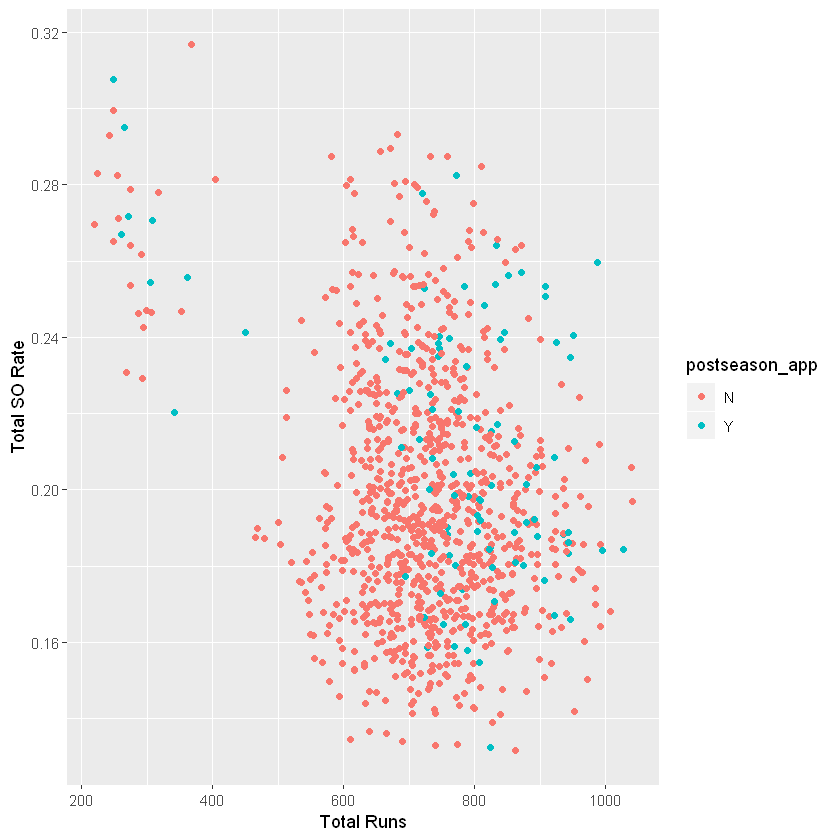

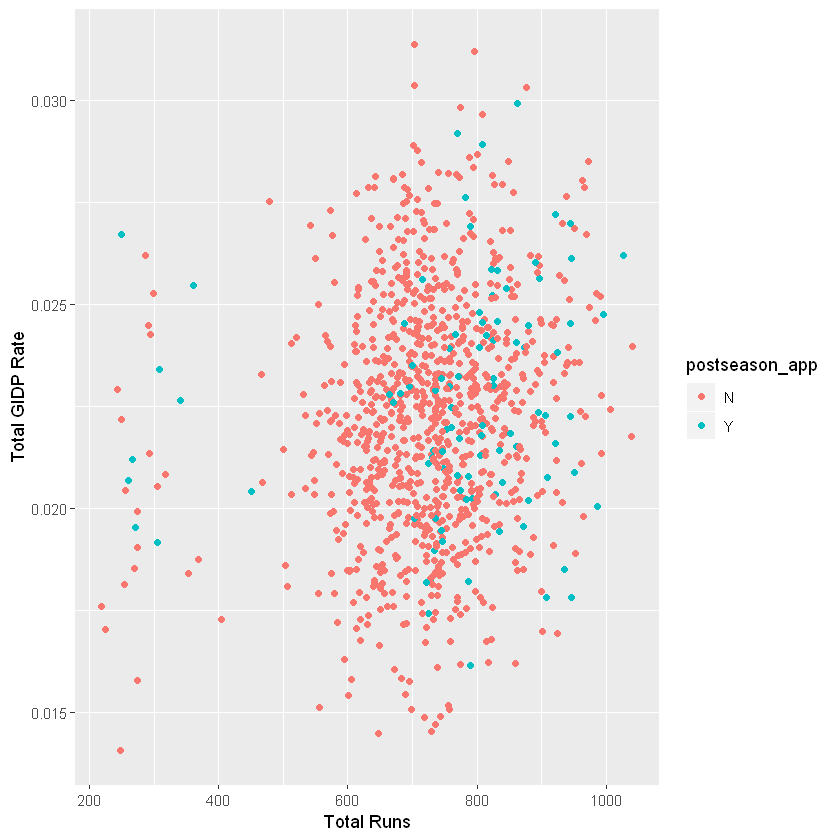

In [217]:
teamsummary %>%
  ggplot(mapping = aes(x = total_R, y = total_Kperc)) +
  geom_point(aes(colour = postseason_app)) + 
  labs(x = "Total Runs", y = "Total SO Rate")

teamsummary %>%
  ggplot(mapping = aes(x = total_R, y = total_GIDPperc)) +
  geom_point(aes(colour = postseason_app)) + 
  labs(x = "Total Runs", y = "Total GIDP Rate")

A blue instance indicates a team that has made the postseason, and for both graphs we see a higher horizontal shift (to the right), while not necessarily skewing vertically. A horizontal shift indicates a higher importance for the number of runs in terms of correlation with postseason appearance. 

### 7. Salary/Payroll

A team's payroll is defined as how much money it spends on hiring a player. We have the payroll data for each teams. It's not completely accurate, as there are some salary data that is not available, but there is data for most players, so this is the best we could do.


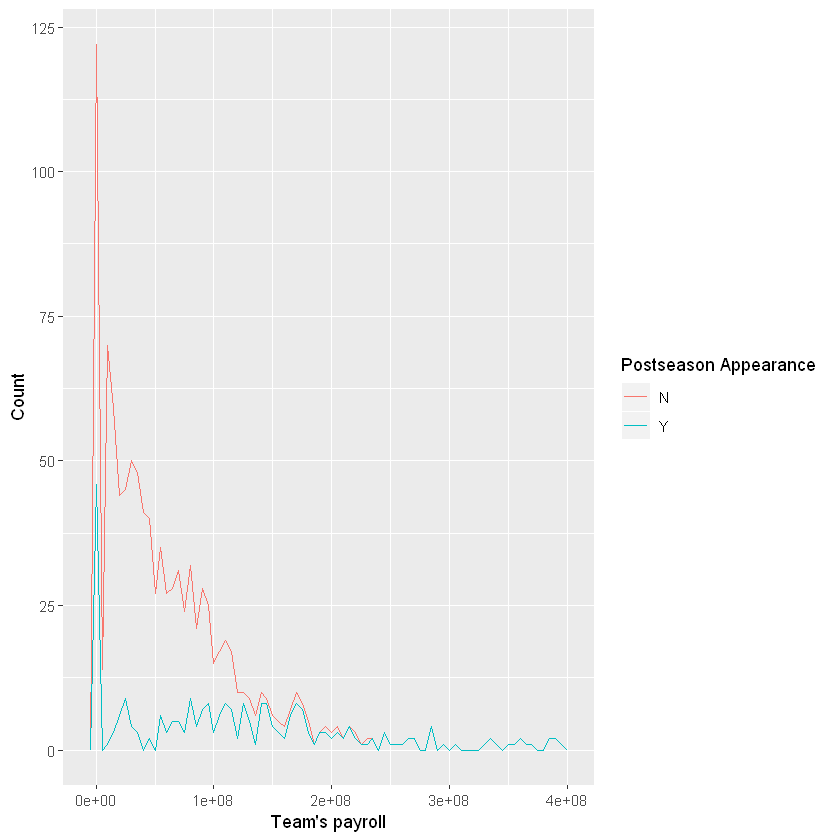

In [218]:
teamsummary %>%
  ggplot(mapping = aes(x = total_salary)) + 
  geom_freqpoly(mapping = aes(colour = postseason_app), binwidth = 5000000)+
  labs(x = "Team's payroll", y = "Count", colour = "Postseason Appearance")

On points that exceed 20 million (20e+08), we can see that there are only spikes visible for the graph of postseason teams. Amount of money a team spends on a player seems to be a fairly good indicator of a team's performance and its likelihood to make it into the postseason.\
\
We can confirm this though a covariance relationship of total salary and total runs scored. 

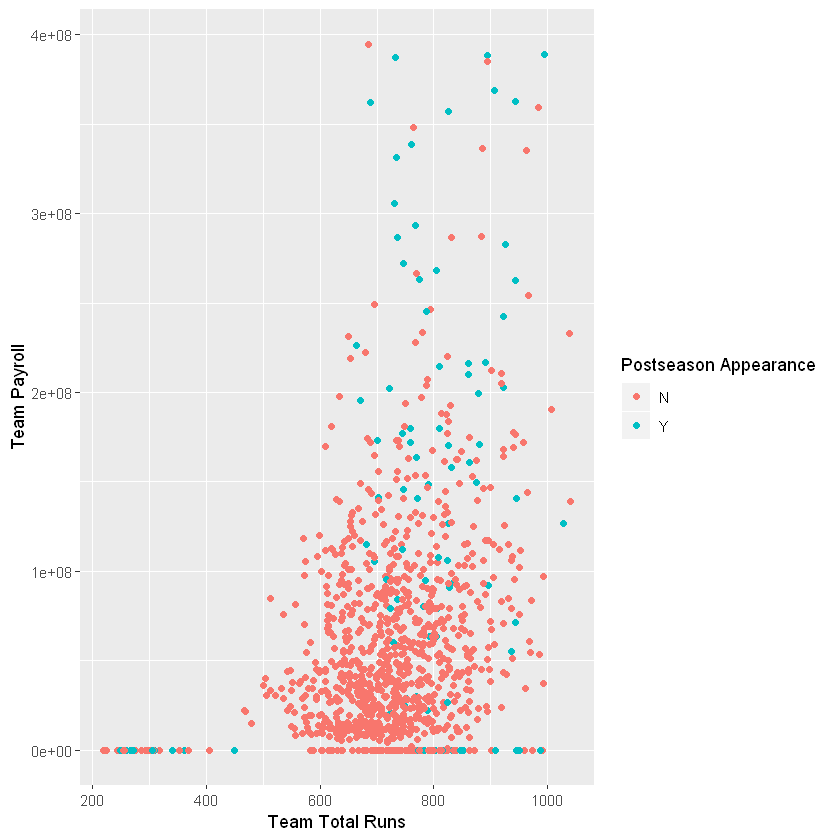

In [219]:
teamsummary %>%
  ggplot(mapping = aes(x = total_R, y = total_salary)) +
  geom_point(aes(colour = postseason_app))+
  labs(x = "Team Total Runs", y = "Team Payroll", colour = "Postseason Appearance")

This graph clearly shows that salary is a dominant factor in determining a team's postseason appearance likelihood. We can see that teams above a certain payroll (around 25 million) all make it into the postseason, despite how many runs they scored! We can see a similar trend with payroll vs. homeruns.


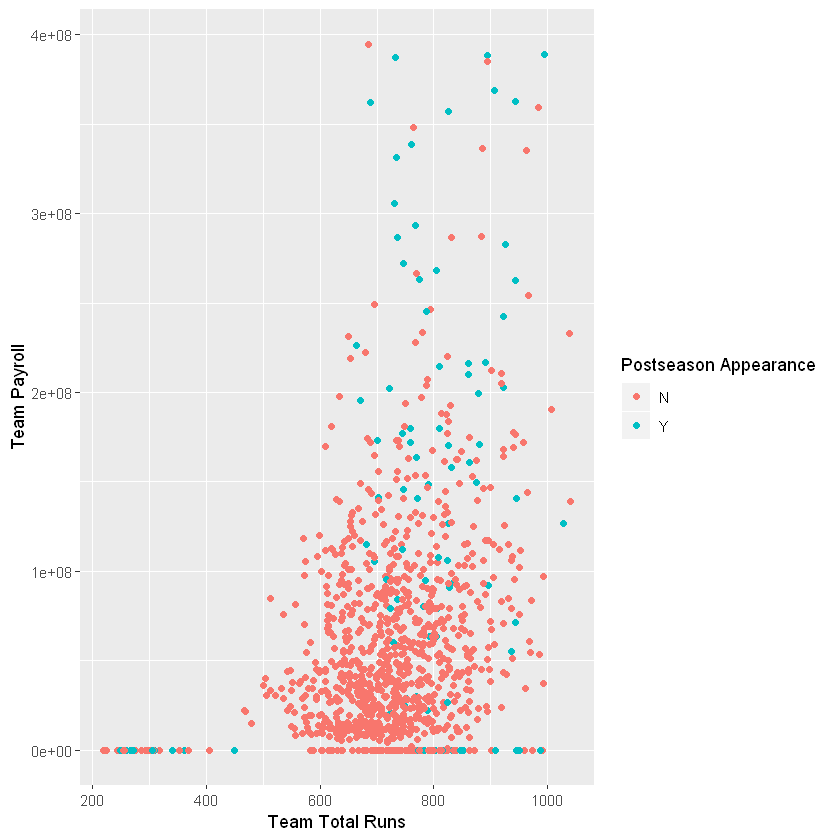

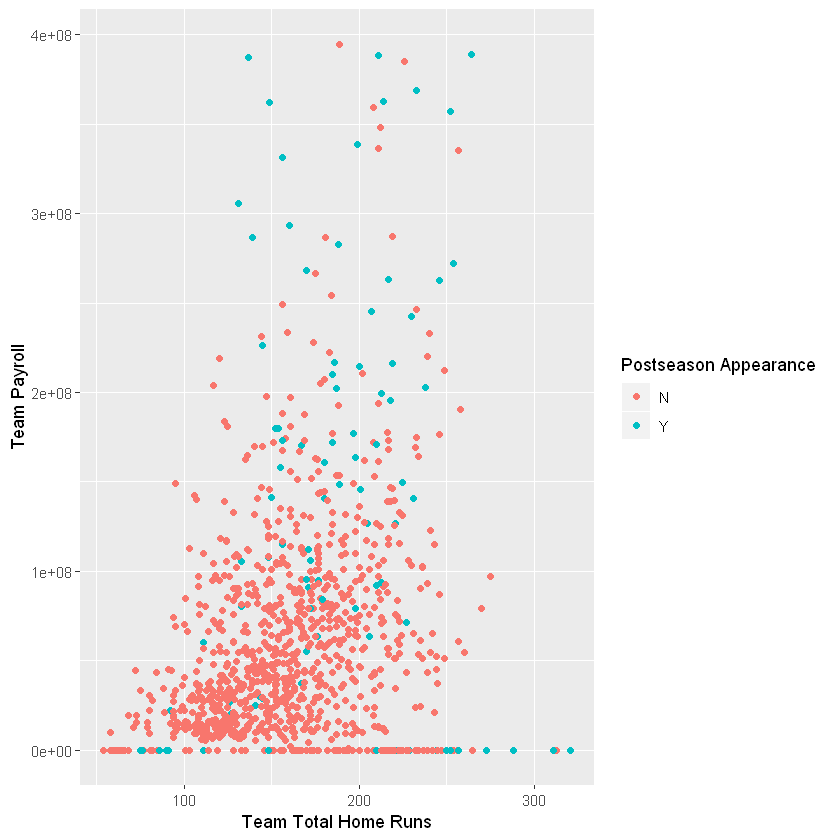

In [220]:
teamsummary %>%
  ggplot(mapping = aes(x = total_R, y = total_salary)) +
  geom_point(aes(colour = postseason_app)) +
  labs(x = "Team Total Runs", y = "Team Payroll", colour = "Postseason Appearance")

teamsummary %>%
  ggplot(mapping = aes(x = total_HR, y = total_salary)) +
  geom_point(aes(colour = postseason_app)) +
  labs(x = "Team Total Home Runs", y = "Team Payroll", colour = "Postseason Appearance")

Through analysis of the data we could see that a team's payroll (total salary paid) is the most determinant factor of a team's postseason apperance, then the number of runs and home runs scored, then the rate of Strikeouts/GIDPs, then finally the collective batting average of a team. 


# E. Conclusions 

In the initial data exploration, EDA of the Lahman dataset confirms the "common sense" trends of baseball. The result from the second part disproves my original hypothesis that the total runs scored is the greatest determinant of a team's likelihood of reaching the postseason. As determined by EDA, payroll can have a great deal of variance with a lot of outliers. This means that teams with a high payroll would have spent a lot of money on particular players that perform extremely well. Although baseball is known as a team sport that is notoriously difficult to predict the results of, this conclusion suggests that having key individual players can have an immense impact in a team's performance. The error of my original hypothesis suggests that I overemphasized collective performance over performance due to individual contribution. 

Futher analysis can be conducted to take yearly inflation into account for salary, as \\$1 in 1985 is worth more than \\$2. As payroll is an important factor in a team's performance, it would be interesting to dive further into the salary data and quantify the valuation of players. Brief look at the data suggested a general increase in odds of a team with a high payroll making the postseason, but overpaying for players, especially in teams with a tight budget, can be detrimental for multiple consecutive seasons. With the prepared data, I can also examine regression of players by appending more statistics to examine factors that contribute to regression time periods and regression rates, using machine learning algorithms. 
